In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
from IPython.core.display import display, HTML, display_pretty
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from imblearn.datasets import make_imbalance
os.chdir('/home/sambeet/data/dsg/')

In [121]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')
trade['year'] = trade.TradeDateKey.dt.year
trade['month'] = trade.TradeDateKey.dt.month
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear
trade = trade.groupby(['CustomerIdx','IsinIdx','BuySell','year','month','weekofyear'])['CustomerInterest'].sum().reset_index()
trade['CustomerInterest'] = trade.CustomerInterest > 1
#marketdata = pd.read_csv('Market.csv',parse_dates=['DateKey'])
#macromarketdata = pd.read_csv('MarketData_Macro.csv',parse_dates=['DateKey'])
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
trade = trade.merge(customer,on=['CustomerIdx'],how='left')
bond = bond.rename({'Region':'BondRegion'},axis=1)
trade = trade.merge(bond,on=['IsinIdx'],how='left')
#trade['days_issued'] = (trade['TradeDateKey'] - trade['IssueDateKey']).dt.days
#trade['days_maturity'] = (trade['ActualMaturityDateKey'] - trade['TradeDateKey']).dt.days
#test_submit['days_issued'] = (test_submit['TradeDateKey'] - test_submit['IssueDateKey']).dt.days
#test_submit['days_maturity'] = (test_submit['ActualMaturityDateKey'] - test_submit['TradeDateKey']).dt.days
del customer, bond
gc.collect()
categorical_to_be_transformed = ['BuySell','Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade[feature].astype(str))    
    trade[feature] = encoder.transform(trade[feature].astype(str))
#   test_submit[feature] = encoder.transform(test_submit[feature].astype(str))

Transforming BuySell...
Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


In [122]:
trade.head()

,CustomerIdx,IsinIdx,BuySell,year,month,weekofyear,CustomerInterest,Sector,Subsector,CustomerRegion,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,0,16471,0,2017,5,20,False,0,24,1,...,1,2,1,0,11,7,247,5,5.500000e+08,0
1,0,16499,0,2017,6,23,False,0,24,1,...,1,2,1,0,9,7,247,5,1.500000e+09,0
2,0,20601,0,2017,6,24,False,0,24,1,...,1,2,1,0,7,7,247,5,2.500000e+08,0
3,0,20737,0,2017,6,26,False,0,24,1,...,1,2,1,0,28,7,247,5,5.000000e+08,4
4,0,20909,1,2016,11,45,True,0,24,1,...,1,2,1,0,28,9,81,5,4.000000e+08,0


In [123]:
categorical_holdings = categorical_to_be_transformed + ['year','CustomerIdx','IsinIdx','weekofyear']
#categorical.remove('BuySell')
predictors_holdings = list(trade.columns)
#predictors.remove('TradeDateKey')
#predictors.remove('IsinIdx')
#predictors.remove('Price')
predictors_holdings.remove('CustomerInterest')
#predictors.remove('BuySell')
predictors_holdings.remove('ActualMaturityDateKey')
predictors_holdings.remove('IssueDateKey')
#predictors.remove('TradeStatus')
#predictors.remove('NotionalEUR')
#predictors.remove('BondPrice')
#predictors.remove('Yield')
#predictors.remove('ZSpread')
#predictors.remove('day')
#predictors.remove('weekday')
predictors_holdings.remove('TickerIdx')
#predictors_holdings.remove('weekofyear')
predictors_holdings.remove('month')
#predictors.remove('CustomerIdx')

target_holdings = 'CustomerInterest'
print(predictors_holdings,categorical_holdings,len(predictors_holdings),trade.shape[0])

(['CustomerIdx', 'IsinIdx', 'BuySell', 'year', 'weekofyear', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'IssuedAmount', 'CouponType'], ['BuySell', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType', 'year', 'CustomerIdx', 'IsinIdx', 'weekofyear'], 22, 6280924)


categorical = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
predictors = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
target = 'BuySell'
print(predictors,categorical,len(predictors),trade.shape[0],test.shape[0])

In [124]:
#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int),
#                                                                         1:np.sum(trade.CustomerInterest == 1)},random_state=37)

#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.sum(trade.CustomerInterest == 0),
#                                                                         1:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int)},random_state=37)
trade = trade.sort_values(['year','month','weekofyear']).reset_index(drop=True)
valid_index = list(trade[(trade.year == 2018) & (trade.weekofyear >= 13)].index)
all_index = list(trade.index)
train_index = list(set(all_index) - set(valid_index))
len(all_index) - len(train_index) - len(valid_index)
x_train = trade.loc[train_index,predictors_holdings].values
y_train = trade.loc[train_index,target_holdings].values
x_valid = trade.loc[valid_index,predictors_holdings].values
y_valid = trade.loc[valid_index,target_holdings].values
#train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.2, random_state=37)
#train_index = range(3494374)
#valid_index = range(3494374,3729982) + range(3786265,3920366) + range(6536514,6682124)
#trade_undersampled.shape

In [125]:
rounds = 10000
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 10,
#    'max_depth': 3,
    'learning_rate' : 0.1,
    'feature_fraction' : 1,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : 1,
    'num_threads' : 8,
#    'min_data_in_leaf' : 10000,
#    'lambda_l1' : 1,
#    'lambda_l2' : 1,
#    'cat_smooth' : 50,
#    'max_bin' : 50,
    'scale_pos_weight' : 0.1
}

In [126]:
# LGBM Dataset Formatting 
train = lgb.Dataset(x_train,y_train,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
valid = lgb.Dataset(x_valid,y_valid,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
model_holdings = lgb.train(lgbm_params,train,num_boost_round=rounds,valid_sets=[train,valid],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=50)
#del x_valid ; x_train; gc.collect()

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.886671	valid's auc: 0.837838
[100]	train's auc: 0.903572	valid's auc: 0.869226
[150]	train's auc: 0.907081	valid's auc: 0.871683
[200]	train's auc: 0.9089	valid's auc: 0.872662
[250]	train's auc: 0.909996	valid's auc: 0.872971
[300]	train's auc: 0.911083	valid's auc: 0.87317
[350]	train's auc: 0.91206	valid's auc: 0.873498
[400]	train's auc: 0.912975	valid's auc: 0.873809
[450]	train's auc: 0.913587	valid's auc: 0.873862
[500]	train's auc: 0.914171	valid's auc: 0.873998
[550]	train's auc: 0.915083	valid's auc: 0.874619
Early stopping, best iteration is:
[528]	train's auc: 0.914886	valid's auc: 0.874792


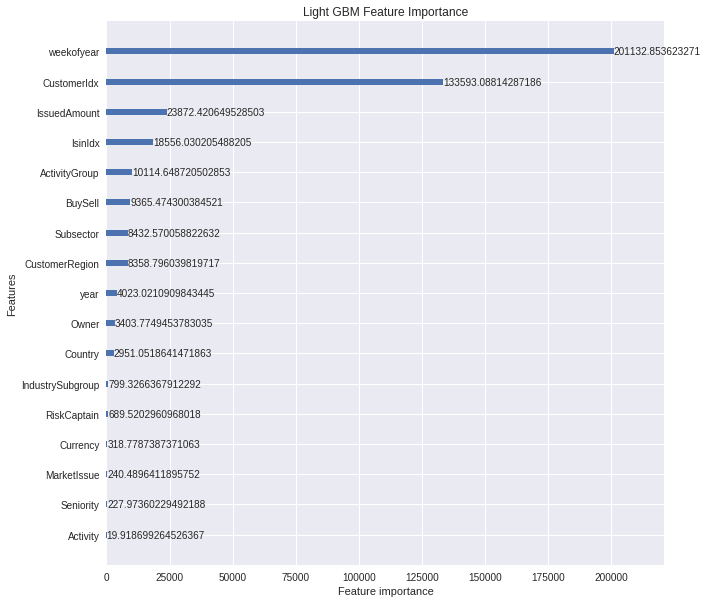

In [127]:
lgb.plot_importance(model_holdings,importance_type='gain',figsize=(10,10))
plt.title("Light GBM Feature Importance")

In [27]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')
trade['year'] = trade.TradeDateKey.dt.year
trade['month'] = trade.TradeDateKey.dt.month
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear

In [28]:
trade.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest,year,month,weekofyear
0,2016-12-07,2789,8478,Sell,653168.0,0.0,Unknown,True,2016,12,49
1,2017-03-29,2574,14562,Buy,1656487.0,0.0,Unknown,True,2017,3,13
2,2017-04-18,2574,4747,Buy,939673.0,0.0,Unknown,True,2017,4,16
3,2017-03-10,2574,9885,Sell,708082.0,0.0,Unknown,True,2017,3,10
4,2016-11-16,2574,8885,Buy,1147709.0,0.0,Unknown,True,2016,11,46


In [46]:
#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int),
#                                                                         1:np.sum(trade.CustomerInterest == 1)},random_state=37)

#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.sum(trade.CustomerInterest == 0),
#                                                                         1:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int)},random_state=37)
trade = trade[trade.CustomerInterest == True].sort_values(['year','month','weekofyear']).reset_index(drop=True)
valid_index = list(trade[(trade.year == 2018) & (trade.weekofyear >= 13)].index)
all_index = list(trade.index)
train_index = list(set(all_index) - set(valid_index))
len(all_index) - len(train_index) - len(valid_index)
x_train = trade.loc[train_index,:]
x_valid = trade.loc[valid_index,:]
#train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.2, random_state=37)
#train_index = range(3494374)
#valid_index = range(3494374,3729982) + range(3786265,3920366) + range(6536514,6682124)
#trade_undersampled.shape

In [47]:
x_train = x_train.groupby(['CustomerIdx','IsinIdx','BuySell'])['CustomerInterest'].sum().reset_index()
#x_train['CustomerInterest'] = x_train.CustomerInterest >= 1

In [48]:
gp = x_train.groupby('CustomerIdx')['CustomerInterest'].sum().reset_index()
x_train = x_train.merge(gp,on='CustomerIdx',how='left')
x_train.head()

,CustomerIdx,IsinIdx,BuySell,CustomerInterest_x,CustomerInterest_y
0,0,16471,Buy,1.0,42.0
1,0,16499,Buy,1.0,42.0
2,0,20601,Buy,1.0,42.0
3,0,20737,Buy,1.0,42.0
4,0,20909,Sell,2.0,42.0


In [50]:
x_train['predCustomerInterest'] = x_train.CustomerInterest_x.astype(int)/x_train.CustomerInterest_y
x_train = x_train.drop(['CustomerInterest_x','CustomerInterest_y'],axis=1).drop_duplicates()
x_train.head()

,CustomerIdx,IsinIdx,BuySell,predCustomerInterest
0,0,16471,Buy,0.023810
1,0,16499,Buy,0.023810
2,0,20601,Buy,0.023810
3,0,20737,Buy,0.023810
4,0,20909,Sell,0.047619


In [51]:
x_valid = x_valid.groupby(['CustomerIdx','IsinIdx','BuySell','year','weekofyear'])['CustomerInterest'].sum().reset_index()
x_valid['CustomerInterest'] = x_valid.CustomerInterest >= 1
x_valid.head()

,CustomerIdx,IsinIdx,BuySell,year,weekofyear,CustomerInterest
0,0,27045,Buy,2018,16,True
1,0,27298,Sell,2018,16,True
2,2,5215,Sell,2018,13,True
3,2,16812,Sell,2018,13,True
4,2,16812,Sell,2018,14,True


In [52]:
#Create valid
filtered = x_valid.reset_index(drop=True)
filtered = filtered.drop_duplicates()
#filtered = filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear']]
filtered_sell = filtered[['CustomerIdx','IsinIdx']].drop_duplicates()
filtered_buy = filtered_sell.copy()
filtered_sell['BuySell'] = 'Sell'
filtered_buy['BuySell'] = 'Buy'
filtered_valid_1 = pd.concat([filtered_sell,filtered_buy],axis=0)
filtered_valid_1['year'] = 2018.
filtered_valid_1['weekofyear'] = 13
filtered_valid_2 = filtered_valid_1.copy()
filtered_valid_2['weekofyear'] = 14
filtered_valid_3 = filtered_valid_1.copy()
filtered_valid_3['weekofyear'] = 15
filtered_valid_4 = filtered_valid_1.copy()
filtered_valid_4['weekofyear'] = 16
filtered_valid = pd.concat([filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4],axis=0)
del filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4,filtered_buy,filtered_sell
gc.collect()
filtered_valid = filtered_valid.merge(filtered,on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
filtered_valid['CustomerInterest'][filtered_valid.CustomerInterest.isnull()] = False
filtered_valid.head()

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,CustomerIdx,IsinIdx,BuySell,year,weekofyear,CustomerInterest
0,0,27045,Sell,2018.0,13,False
1,0,27298,Sell,2018.0,13,False
2,2,5215,Sell,2018.0,13,True
3,2,16812,Sell,2018.0,13,True
4,2,17091,Sell,2018.0,13,True


trade['BuySell'] = trade['BuySell'].astype('category')
encoder = LabelEncoder()
encoder.fit(trade['BuySell'].astype(str))    
trade['BuySell'] = encoder.transform(trade['BuySell'].astype(str))

encoder.transform(['Buy','Sell'])

In [53]:
filtered_valid = filtered_valid.merge(x_train,on=['CustomerIdx','IsinIdx','BuySell'])
filtered_valid.head()

,CustomerIdx,IsinIdx,BuySell,year,weekofyear,CustomerInterest,predCustomerInterest
0,0,27045,Sell,2018.0,13,False,0.023810
1,0,27045,Sell,2018.0,14,False,0.023810
2,0,27045,Sell,2018.0,15,False,0.023810
3,0,27045,Sell,2018.0,16,False,0.023810
4,2,17091,Sell,2018.0,13,True,0.076923


In [54]:
from sklearn.metrics import roc_auc_score
y_true = filtered_valid.CustomerInterest.astype(int).values
y_scores = filtered_valid.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

0.5284004641785228

In [132]:
trade.shape

(1783648, 7)

In [133]:
#marketdata = pd.read_csv('Market.csv',parse_dates=['DateKey'])
#macromarketdata = pd.read_csv('MarketData_Macro.csv',parse_dates=['DateKey'])
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
trade = trade.merge(customer,on=['CustomerIdx'],how='left')
bond = bond.rename({'Region':'BondRegion'},axis=1)
trade = trade.merge(bond,on=['IsinIdx'],how='left')
#trade['days_issued'] = (trade['TradeDateKey'] - trade['IssueDateKey']).dt.days
#trade['days_maturity'] = (trade['ActualMaturityDateKey'] - trade['TradeDateKey']).dt.days
test_submit = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test_submit = test_submit.rename({'DateKey':'TradeDateKey'},axis=1)
test_submit['BuySell'] = test_submit['BuySell'].astype('category')
test_submit['TradeDateKey'] = '20180423'
test_submit['TradeDateKey'] = pd.to_datetime(test_submit.TradeDateKey)
test_submit['year'] = test_submit.TradeDateKey.dt.year
test_submit['month'] = test_submit.TradeDateKey.dt.month
test_submit['weekofyear'] = test_submit.TradeDateKey.dt.weekofyear
test_submit = test_submit.merge(customer,on=['CustomerIdx'],how='left')
test_submit = test_submit.merge(bond,on=['IsinIdx'],how='left')
#test_submit['days_issued'] = (test_submit['TradeDateKey'] - test_submit['IssueDateKey']).dt.days
#test_submit['days_maturity'] = (test_submit['ActualMaturityDateKey'] - test_submit['TradeDateKey']).dt.days
del customer, bond
gc.collect()
categorical_to_be_transformed = ['BuySell','Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade[feature].append(test_submit[feature]).astype(str))    
    trade[feature] = encoder.transform(trade[feature].astype(str))
    test_submit[feature] = encoder.transform(test_submit[feature].astype(str))

Transforming BuySell...
Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


trade['wom'] = trade['TradeDateKey'].apply(lambda d: (d.day-1) // 7 + 1)
test['wom'] = test['TradeDateKey'].apply(lambda d: (d.day-1) // 7 + 1)

In [134]:
categorical = categorical_to_be_transformed + ['year','CustomerIdx','IsinIdx']#,'quarter','weekofyear']
categorical.remove('BuySell')
predictors = list(trade.columns)
#predictors.remove('TradeDateKey')
#predictors.remove('IsinIdx')
#predictors.remove('Price')
predictors.remove('CustomerInterest')
predictors.remove('BuySell')
predictors.remove('ActualMaturityDateKey')
predictors.remove('IssueDateKey')
#predictors.remove('TradeStatus')
#predictors.remove('NotionalEUR')
#predictors.remove('BondPrice')
#predictors.remove('Yield')
#predictors.remove('ZSpread')
#predictors.remove('day')
#predictors.remove('weekday')
predictors.remove('TickerIdx')
predictors.remove('weekofyear')
predictors.remove('month')
#predictors.remove('CustomerIdx')

target = 'BuySell'
print(predictors,categorical,len(predictors),trade.shape[0],test_submit.shape[0])

(['CustomerIdx', 'IsinIdx', 'year', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'IssuedAmount', 'CouponType'], ['Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType', 'year', 'CustomerIdx', 'IsinIdx'], 20, 1783648, 484758)


categorical = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
predictors = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
target = 'BuySell'
print(predictors,categorical,len(predictors),trade.shape[0],test.shape[0])

In [135]:
#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int),
#                                                                         1:np.sum(trade.CustomerInterest == 1)},random_state=37)

#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.sum(trade.CustomerInterest == 0),
#                                                                         1:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int)},random_state=37)
trade = trade.sort_values(['year','month','weekofyear']).reset_index(drop=True)
valid_index = list(trade[(trade.year == 2018) & (trade.weekofyear >= 13)].index)
all_index = list(trade.index)
train_index = list(set(all_index) - set(valid_index))
len(all_index) - len(train_index) - len(valid_index)
x_train = trade.loc[train_index,predictors].values
y_train = trade.loc[train_index,target].values
x_valid = trade.loc[valid_index,predictors].values
y_valid = trade.loc[valid_index,target].values
#train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.2, random_state=37)
#train_index = range(3494374)
#valid_index = range(3494374,3729982) + range(3786265,3920366) + range(6536514,6682124)
#trade_undersampled.shape

In [136]:
rounds = 10000
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 10,
#    'max_depth': 3,
    'learning_rate' : 0.1,
#    'feature_fraction' : 0.5,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : 1,
    'num_threads' : 8,
#    'min_data_in_leaf' : 10000,
#    'lambda_l1' : 1,
#    'lambda_l2' : 1,
#    'cat_smooth' : 50,
#    'max_bin' : 50,
#    'scale_pos_weight' : 3
}

In [137]:
# LGBM Dataset Formatting 
train = lgb.Dataset(x_train,y_train,feature_name=predictors,categorical_feature = categorical)
valid = lgb.Dataset(x_valid,y_valid,feature_name=predictors,categorical_feature = categorical)
model = lgb.train(lgbm_params,train,num_boost_round=rounds,valid_sets=[train,valid],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=50)
#del x_valid ; x_train; gc.collect()

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.6466	valid's auc: 0.622214
[100]	train's auc: 0.66149	valid's auc: 0.629693
[150]	train's auc: 0.671452	valid's auc: 0.634629
[200]	train's auc: 0.677218	valid's auc: 0.637063
[250]	train's auc: 0.681471	valid's auc: 0.638793
[300]	train's auc: 0.685548	valid's auc: 0.640281
[350]	train's auc: 0.688966	valid's auc: 0.641111
[400]	train's auc: 0.692473	valid's auc: 0.642025
[450]	train's auc: 0.695498	valid's auc: 0.643318
[500]	train's auc: 0.698155	valid's auc: 0.644146
[550]	train's auc: 0.7011	valid's auc: 0.644949
[600]	train's auc: 0.703741	valid's auc: 0.645558
[650]	train's auc: 0.705697	valid's auc: 0.646009
[700]	train's auc: 0.707583	valid's auc: 0.646439
[750]	train's auc: 0.709407	valid's auc: 0.646529
[800]	train's auc: 0.711037	valid's auc: 0.646816
[850]	train's auc: 0.712562	valid's auc: 0.647231
[900]	train's auc: 0.714012	valid's auc: 0.647758
[950]	train's auc: 0.715488	valid's auc: 0.6

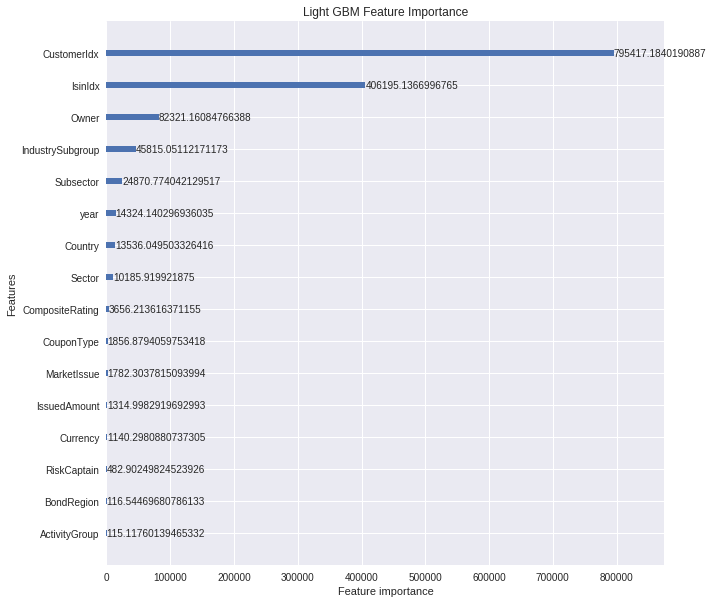

In [138]:
lgb.plot_importance(model,importance_type='gain',figsize=(10,10))
plt.title("Light GBM Feature Importance")

x = test[test.BuySell == 'Sell']['CustomerInterest']#.describe()
sns.distplot(x)

import catboost as cb
cat_features_index = [0,1]

'''
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(train, y_train)
'''
#With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=255,depth=3, iterations= 100, l2_leaf_reg= 9, learning_rate= 0.01)
clf.fit(trade.loc[train_index,predictors],trade.loc[train_index,target], cat_features= cat_features_index,
       eval_set=(trade.loc[valid_index,predictors],trade.loc[valid_index,target]),plot=True)

In [139]:
#Create valid
filtered = trade[(trade.year == 2018) & (trade.weekofyear >= 13) & (trade.CustomerInterest == True)].reset_index(drop=True)
filtered = filtered.drop_duplicates()
#filtered = filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear']]
filtered_sell = filtered[['CustomerIdx','IsinIdx']].drop_duplicates()
filtered_buy = filtered_sell.copy()
filtered_sell['BuySell'] = 1
filtered_buy['BuySell'] = 0
filtered_valid_1 = pd.concat([filtered_sell,filtered_buy],axis=0)
filtered_valid_1['year'] = 2018.
filtered_valid_1['weekofyear'] = 13
filtered_valid_2 = filtered_valid_1.copy()
filtered_valid_2['weekofyear'] = 14
filtered_valid_3 = filtered_valid_1.copy()
filtered_valid_3['weekofyear'] = 15
filtered_valid_4 = filtered_valid_1.copy()
filtered_valid_4['weekofyear'] = 16
filtered_valid = pd.concat([filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4],axis=0)
del filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4,filtered_buy,filtered_sell
gc.collect()
filtered_valid = filtered_valid.merge(filtered,on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
filtered_valid['CustomerInterest'][filtered_valid.CustomerInterest.isnull()] = 0
filtered_valid.head()

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,CustomerIdx,IsinIdx,BuySell,year,weekofyear,month,CustomerInterest,Sector,Subsector,CustomerRegion,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,2,5215,1,2018.0,13,3.0,True,0.0,23.0,0.0,...,0.0,0.0,0.0,17.0,7.0,8.0,293.0,7.0,3.245605e+09,0.0
1,2,17275,1,2018.0,13,3.0,True,0.0,23.0,0.0,...,0.0,12.0,11.0,18.0,7.0,7.0,48.0,3.0,7.500000e+08,4.0
2,14,15545,1,2018.0,13,3.0,True,0.0,23.0,2.0,...,0.0,12.0,11.0,18.0,15.0,1.0,186.0,7.0,2.250000e+09,0.0
3,19,6121,1,2018.0,13,3.0,True,0.0,41.0,0.0,...,0.0,7.0,22.0,83.0,3.0,7.0,227.0,7.0,2.000000e+09,0.0
4,19,15679,1,2018.0,13,3.0,True,0.0,41.0,0.0,...,0.0,7.0,24.0,97.0,2.0,12.0,91.0,10.0,5.500000e+08,0.0


In [140]:
filtered_valid['predInterest'] = model_holdings.predict(filtered_valid.loc[:,predictors_holdings].values)
filtered_valid['probBuySell'] = model.predict(filtered_valid.loc[:,predictors].values)
filtered_valid['probBuySell'][filtered_valid.BuySell == 0] = 1 - filtered_valid['probBuySell'][filtered_valid.BuySell == 0]

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
filtered_valid['predCustomerInterest'] = filtered_valid.predInterest*filtered_valid.probBuySell
filtered_valid.predCustomerInterest.describe()

count    75792.000000
mean         0.010670
std          0.011939
min          0.000003
25%          0.004443
50%          0.008373
75%          0.013255
max          0.517144
Name: predCustomerInterest, dtype: float64

In [142]:
from sklearn.metrics import roc_auc_score
y_true = filtered_valid.CustomerInterest.astype(int).values
y_scores = filtered_valid.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

0.506716434767881

In [143]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
encoder = LabelEncoder()
encoder.fit(test['BuySell'].astype(str))
test['BuySell'] = encoder.transform(test['BuySell'].astype(str))
encoder.transform(['Buy','Sell'])
#test['CustomerInterest'] = model.predict(test.loc[:,predictors].values)
#test['CustomerInterest'][test.BuySell == 'Buy'] = 1 - test['CustomerInterest'][test.BuySell == 'Buy']
#test[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_buysell.csv', index=False)

array([0, 1])

In [144]:
test_13 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_13['weekofyear'] = 13
test_14 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_14['weekofyear'] = 14
test_15 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_15['weekofyear'] = 15
test_16 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_16['weekofyear'] = 16
test_local = pd.concat([test_13,test_14,test_15,test_16],axis=0)
del test_13,test_14,test_15,test_16
gc.collect()
trade2 = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade2['BuySell'] = trade2['BuySell'].astype('category')
trade2['TradeStatus'] = trade2['TradeStatus'].astype('category')
trade2['CustomerInterest'] = trade2['CustomerInterest'].astype('bool')
trade2['year'] = trade2.TradeDateKey.dt.year
trade2['month'] = trade2.TradeDateKey.dt.month
trade2['weekofyear'] = trade2.TradeDateKey.dt.weekofyear
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)

bond = bond.rename({'Region':'BondRegion'},axis=1)
trade2 = trade2.merge(customer,on=['CustomerIdx'],how='left')
trade2 = trade2.merge(bond,on=['IsinIdx'],how='left')
test = test.merge(customer,on=['CustomerIdx'],how='left')
test = test.merge(bond,on=['IsinIdx'],how='left')
test_local = test_local.merge(customer,on=['CustomerIdx'],how='left')
test_local = test_local.merge(bond,on=['IsinIdx'],how='left')

categorical_to_be_transformed = ['Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade2[feature].append(test[feature]).astype(str))    
    test_local[feature] = encoder.transform(test_local[feature].astype(str))

test_local = test_local.merge(filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear','CustomerInterest']],on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
test_local['CustomerInterest'][test_local.CustomerInterest.isnull()] = 0
test_local.head()

Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,year,weekofyear,Sector,Subsector,CustomerRegion,Country,...,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,CustomerInterest
0,a1e0d80784,1856,13323,0,2018,13,0,24,0,95,...,3,4,96,9,4,225,7,4.500000e+08,0,0
1,c2cc6cc2a8,1856,9230,0,2018,13,0,24,0,95,...,3,4,87,7,7,194,10,4.000000e+08,0,0
2,a8e94f6344,1780,9157,0,2018,13,0,1,0,95,...,7,22,83,1,9,81,2,3.000000e+08,1,0
3,758bae1e35,2129,9131,0,2018,13,1,25,0,95,...,7,22,83,1,9,81,7,4.000000e+09,0,0
4,02ab378ee8,1758,7151,0,2018,13,0,1,0,95,...,7,24,79,14,12,92,10,3.000000e+08,0,0


In [145]:
test_local['predInterest'] = model_holdings.predict(test_local.loc[:,predictors_holdings].values)
test_local['probBuySell'] = model.predict(test_local.loc[:,predictors].values)
test_local['probBuySell'][test_local.BuySell == 0] = 1 - test_local['probBuySell'][test_local.BuySell == 0]
test_local['predCustomerInterest'] = test_local.predInterest*test_local.probBuySell
test_local.predCustomerInterest.describe()
y_true = test_local.CustomerInterest.astype(int).values
y_scores = test_local.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.6518915924072854

In [147]:
test_submit.head()

,PredictionIdx,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,month,weekofyear,Sector,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,a1e0d80784,2018-04-23,1856,13323,0,NaN,2018,4,17,0,...,0,3,4,96,9,4,224,7,4.500000e+08,0
1,c2cc6cc2a8,2018-04-23,1856,9230,0,NaN,2018,4,17,0,...,0,3,4,87,7,7,193,10,4.000000e+08,0
2,a8e94f6344,2018-04-23,1780,9157,0,NaN,2018,4,17,0,...,0,7,22,83,1,9,81,2,3.000000e+08,1
3,758bae1e35,2018-04-23,2129,9131,0,NaN,2018,4,17,1,...,0,7,22,83,1,9,81,7,4.000000e+09,0
4,02ab378ee8,2018-04-23,1758,7151,0,NaN,2018,4,17,0,...,0,7,24,79,14,12,91,10,3.000000e+08,0


In [148]:
test_submit['predInterest'] = model_holdings.predict(test_submit.loc[:,predictors_holdings].values)
test_submit['probBuySell'] = model.predict(test_submit.loc[:,predictors].values)
test_submit['probBuySell'][test_submit.BuySell == 0] = 1 - test_submit['probBuySell'][test_submit.BuySell == 0]
test_submit['CustomerInterest'] = test_submit.predInterest*test_submit.probBuySell
test_submit[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_twostepmodel.csv', index=False)

KeyboardInterrupt: 

In [ ]:
test_submit.CustomerInterest.describe()